In [45]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize(mean=0.1307, std=0.3081)

])
train_dataset = datasets.MNIST(root='../dataset', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='../dataset', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d,nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.01)


#这里使用池化层进行下采样并且使用全局平均池化来得到最终答案，激活函数使用relu，并且添加批归一化层(这个东西是会学习参数的)来确保数值更加稳定。
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10,kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=5,kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=5,out_channels=10,kernel_size=3,stride=1,padding=1)
        self.pool3 = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(5)
        self.bn3 = nn.BatchNorm2d(10)

    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1).contiguous()
        return x
model = Net()
model = model.apply(init_weights)
model = model.to(device)


In [47]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [48]:
def train(num_epochs):
    model.train()
    losses = []
    epoches = torch.arange(1, num_epochs+1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        for idx, (x,y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            x,y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()*x.size(0)
            total += y.size(0)
            correct += (y_pred.argmax(dim=1) == y).sum().item()
            if (idx+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}],Batches[{idx+1}/{len(train_dataloader)}], Loss: {running_loss/((idx+1)*(x.size(0))):.3f} , Accuracy: {(100*correct/total):.2f}%")
        losses.append(running_loss/len(train_dataloader.dataset))
        print(f"第{epoch+1}轮的训练精度为：{(100*correct/total):.2f}%\n")
    plt.plot(epoches, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


def test(model):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 不计算梯度
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10],Batches[100/938], Loss: 2.213 , Accuracy: 29.19%
Epoch [1/10],Batches[200/938], Loss: 2.127 , Accuracy: 36.48%
Epoch [1/10],Batches[300/938], Loss: 2.050 , Accuracy: 40.81%
Epoch [1/10],Batches[400/938], Loss: 1.985 , Accuracy: 43.54%
Epoch [1/10],Batches[500/938], Loss: 1.930 , Accuracy: 45.61%
Epoch [1/10],Batches[600/938], Loss: 1.881 , Accuracy: 47.57%
Epoch [1/10],Batches[700/938], Loss: 1.838 , Accuracy: 49.40%
Epoch [1/10],Batches[800/938], Loss: 1.799 , Accuracy: 50.91%
Epoch [1/10],Batches[900/938], Loss: 1.765 , Accuracy: 52.30%
第1轮的训练精度为：52.83%

Epoch [2/10],Batches[100/938], Loss: 1.431 , Accuracy: 67.39%
Epoch [2/10],Batches[200/938], Loss: 1.402 , Accuracy: 68.73%
Epoch [2/10],Batches[300/938], Loss: 1.384 , Accuracy: 69.49%
Epoch [2/10],Batches[400/938], Loss: 1.364 , Accuracy: 70.05%
Epoch [2/10],Batches[500/938], Loss: 1.345 , Accuracy: 70.70%
Epoch [2/10],Batches[600/938], Loss: 1.324 , Accuracy: 71.34%
Epoch [2/10],Batches[700/938], Loss: 1.308 , Accurac

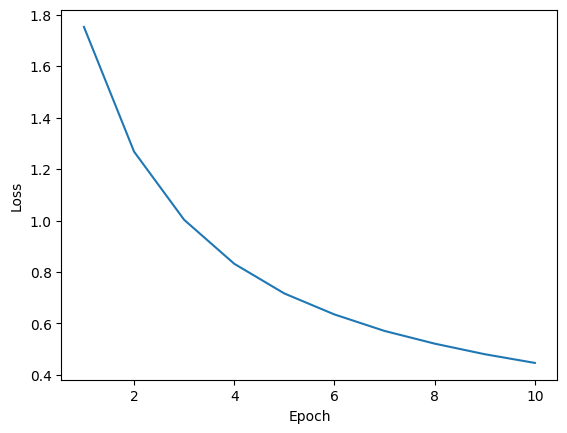

Test Accuracy: 91.92%


In [49]:
if __name__ == '__main__':
    num_epochs = 10
    train(num_epochs)
    test(model)
